In [1]:
import pandas as pd
import numpy as np

In [2]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

stroke = stroke.set_index("id")

stroke_class_0 = stroke[stroke['stroke'] == 0]
stroke_class_1 = stroke[stroke['stroke'] == 1]

stroke_class_1_upsampled = resample(stroke_class_1,
                                    replace=True, 
                                    n_samples=len(stroke_class_0), 
                                    random_state=42)  

stroke_upsampled = pd.concat([stroke_class_0, stroke_class_1_upsampled])
stroke = stroke_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)


test = stroke.drop("stroke", axis=1)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OrdinalEncoder()),
    ])


num_attribs = ["age","avg_glucose_level","bmi"]
# cat_attribs = ["gender","hypertension","heart_disease","Residence_type","smoking_status", "ever_married", "work_type"]
cat_attribs = ["hypertension","heart_disease","smoking_status"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [5]:
stroke_prepared = preprocess_pipeline.fit_transform(test[num_attribs + cat_attribs])

In [6]:
y = stroke["stroke"].copy().tolist()
X = stroke_prepared

In [7]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

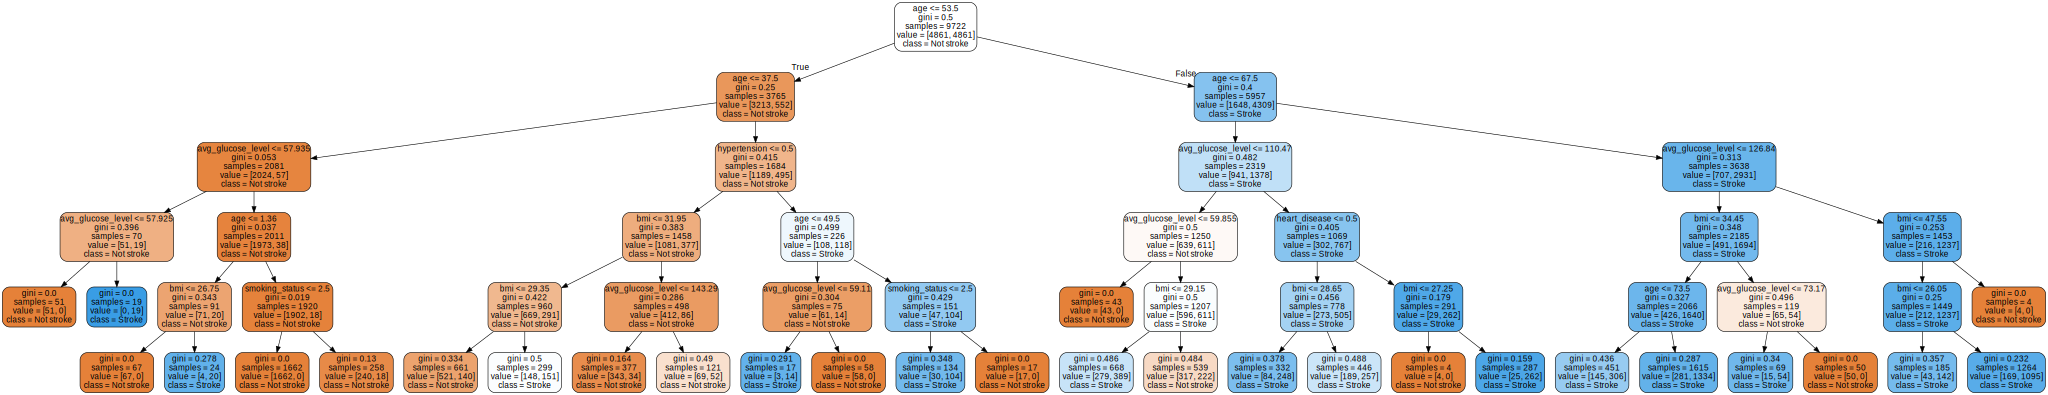

In [8]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "tree.dot"),
        feature_names=num_attribs+cat_attribs,
        class_names=['Not stroke', 'Stroke'],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))


In [9]:
tree_clf.predict_proba([X[-1]])

array([[0.17399381, 0.82600619]])

In [10]:
y[-1]

1

In [11]:
tree_clf.predict_proba([X[1]])

array([[0.2238806, 0.7761194]])

In [12]:
y[1]

1

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=42)

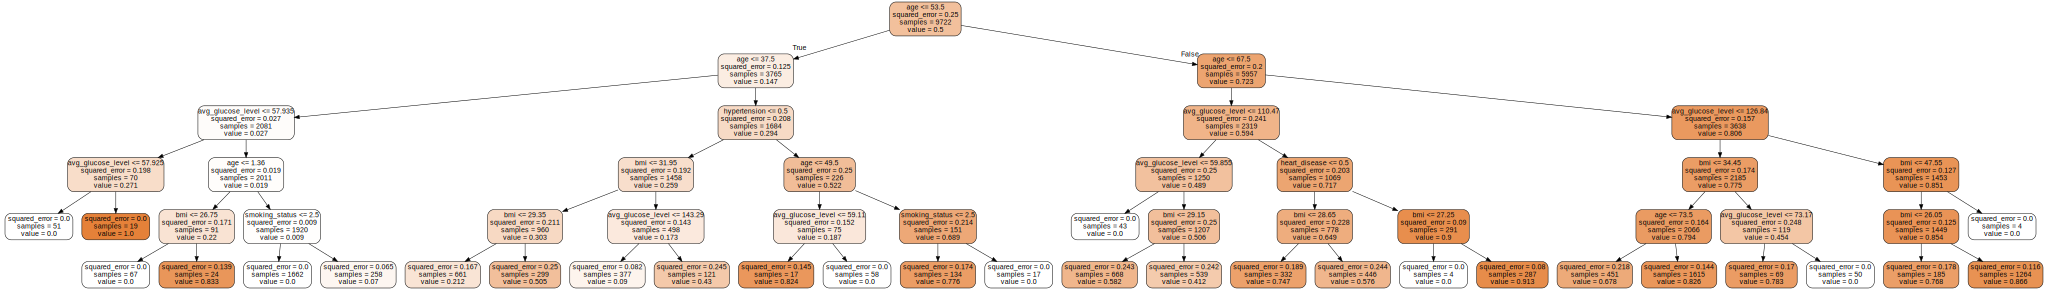

In [14]:
export_graphviz(
        tree_reg,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=num_attribs+cat_attribs,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

## Exercise 7

In [15]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 25)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 69 candidates, totalling 207 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [18]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [19]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## Exercise 8

In [20]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [21]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805471

In [22]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [23]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [24]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

## Testing my dataset

In [25]:
y = stroke["stroke"].copy()
y = y.to_numpy()
X = stroke_prepared

In [26]:
X

array([[ 21.  ,  90.16,  28.9 ,   0.  ,   0.  ,   3.  ],
       [ 52.  , 233.29,  48.9 ,   1.  ,   0.  ,   2.  ],
       [ 55.  ,  73.57,  28.  ,   0.  ,   0.  ,   3.  ],
       ...,
       [ 77.  , 162.14,  32.6 ,   0.  ,   0.  ,   1.  ],
       [ 27.  ,  93.55,  41.6 ,   0.  ,   0.  ,   2.  ],
       [ 80.  ,  91.02,  32.9 ,   1.  ,   0.  ,   1.  ]])

In [27]:
y

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [28]:
unique_values, counts = np.unique(y, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 4861
1: 4861


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#params = {'max_leaf_nodes': list(range(2, 25)), 'min_samples_split': [2, 3, 4], 'max_depth':list(range(2,15))}
params = {'max_leaf_nodes': list(range(2, 25)), 'min_samples_split': [2, 3, 4], 'max_depth':list(range(2,15))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_

Fitting 3 folds for each of 897 candidates, totalling 2691 fits


DecisionTreeClassifier(max_depth=9, max_leaf_nodes=24, random_state=42)

In [30]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8287917737789203